In [1]:
import dolfinx
#import dxh
import ufl
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from petsc4py import PETSc
from scipy.sparse import csr_matrix
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

Define experiment parameters

In [2]:
final_time = 0.9
number_of_time_slices = 4
number_spatial_mesh_cells = 4
time_step = final_time / number_of_time_slices
include_initial_condition = False
spatial_element_degree = 1
temporal_element_degree = 1
# stabilization parameters
lambda_nitsche = 5 * spatial_element_degree**2
gamma_0 = 1
gamma_1 = 1
gamma_m = 1
#gamma_primal_jump = gamma_primal
gamma_dual = 1
gamma_data = 1e4

Set up temporal basis functions for trial and test function spaces

In [3]:
phi_test = phi_trial = (lambda t: 1-t, lambda t: t)
dt_phi_test = dt_phi_trial = (lambda t: -1, lambda t: 1)

Define integrals in time of temporal basis functions, hardcoded here for simplicity

In [4]:
integral_phi_phi = np.array([[1/3, 1/6], [1/6, 1/3]])
integral_dphi_phi = np.array([[-1/2, 1/2], [-1/2, 1/2]])
integral_dphi_dphi = np.array([[1.0, -1.0], [-1.0, 1.0]])

Define quadrature rule for integrating right-hand side with respect to time

In [5]:
class GaussRadauQuadratureRule:

    def __init__(self, number_of_points):
        self.number_of_points = number_of_points
        gauss_radau = {
            3: (
                [-1, (1 - np.sqrt(6)) / 5, (1 + np.sqrt(6)) / 5],
                [2 / 9, (16 + np.sqrt(6)) / 18, (16 - np.sqrt(6)) / 18]
            ),
            4: (
                [-1, -0.575319, 0.181066, 0.822824],
                [0.125, 0.657689, 0.776387, 0.440924]
            )
        }
        self.points, self.weights = gauss_radau[number_of_points]
        
    def current_pts(self, a, b):
        return [0.5 * (b - a) * pt + 0.5 * (b + a)  for pt in self.points]
    
    def t_weights(self, delta_t):
        return [0.5 * delta_t * w for w in self.weights]

quadrature_rule = GaussRadauQuadratureRule(4) # quad rule for integrating rhs

Construct mesh on one-dimensional unit interval spatial domain

In [6]:
communicator = MPI.COMM_WORLD
#mesh = dolfinx.mesh.create_unit_interval(communicator, number_spatial_mesh_cells)
mesh = dolfinx.mesh.create_unit_square(communicator, number_spatial_mesh_cells,number_spatial_mesh_cells)

Create base vector finite element with continuous Galerkin family and dimension proportional to number slices temporal interval is split into

In [7]:
# need to implement divergence freeb CR element in basix
vector_element_primal = ufl.VectorElement(
    family="CG",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices+1
)
vector_element_dual = ufl.VectorElement(
    family="CG",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices
)

Create a mixed element corresponding to outer level of nesting for each of four variables (displacement primal, velocity primal, displacement dual, velocity dual) and corresponding function space

In [8]:
mixed_element = ufl.MixedElement([vector_element_primal,vector_element_dual ])
mixed_function_space = dolfinx.fem.FunctionSpace(mesh, mixed_element)

Construct trial and test functions for primal and dual variables (for both displacement and velocity)

In [9]:
(velocity_primal_trial_function,
    velocity_dual_trial_function,
) = ufl.TrialFunctions(mixed_function_space)
(  velocity_primal_test_function,
    velocity_dual_test_function,
) = ufl.TestFunctions(mixed_function_space)
#(
##    velocity_primal_test_function,
#    velocity_dual_test_function_tmp,
#) = ufl.TestFunctions(mixed_function_space)
#velocity_dual_test_function = [0,velocity_dual_test_function_tmp] 

In [10]:
#help( velocity_dual_test_function )

Create indicator function on spatial domain for where data is available

In [11]:
def data_domain_indicator(spatial_coordinate, lower_bound=0.2, upper_bound=0.8):
    return ((spatial_coordinate[0] <= lower_bound) | (spatial_coordinate[0] >= upper_bound)) * 1

indicator_function_space = dolfinx.fem.FunctionSpace(mesh, ("DG", 0))
data_domain_indicator_function = dolfinx.fem.Function(indicator_function_space)
data_domain_indicator_function.interpolate(data_domain_indicator)

Define function for constructing required measures / integrals on spatial domain and create instances of measures for mesh

In [12]:
def construct_measures(mesh, spatial_element_degree):
    metadata = {"quadrature_degree": 2 * spatial_element_degree + 3}
    cell_integral = ufl.Measure("cell", domain=mesh, metadata=metadata)
    exterior_facet_integral = ufl.Measure("exterior_facet", domain=mesh, metadata=metadata)
    interior_facet_integral = ufl.Measure("interior_facet", domain=mesh, metadata=metadata)
    return cell_integral, exterior_facet_integral, interior_facet_integral

cell_integral, exterior_facet_integral, interior_facet_integral = construct_measures(mesh, spatial_element_degree)
spatial_coordinate = ufl.SpatialCoordinate(mesh)

Definition  of $\tau \partial_{\tau}u^n$

In [13]:
def num_par_der(
    velocity_primal_trial_function_current,
    velocity_primal_trial_function_previous   
):
    return(
            velocity_primal_trial_function_current-velocity_primal_trial_function_previous
            
        )

$A_1(u,w)=\tau \sum^{N}_{n=1}((\partial_{\tau}u^n,w^n)+a_h(u^n,w^n))$

In [14]:
def problem_bilinear_form( 
    #velocity_primal_trial_function,
    velocity_primal_trial_function_current,
    velocity_primal_trial_function_previous,
    velocity_dual_test_function,
    #integral_phi_phi,
    #integral_dphi_phi,
    time_step,
    mesh,
    spatial_element_degree,
):
    cell_integral, exterior_facet_integral, _ = construct_measures(
        mesh, spatial_element_degree
    )
    facet_normal = ufl.FacetNormal(mesh)
    return (
        #integral_dphi_phi
         ufl.inner(
            num_par_der(velocity_primal_trial_function_current, velocity_primal_trial_function_previous),
            velocity_dual_test_function,
        )
        * cell_integral
        + time_step
        * ufl.inner(
            ufl.grad(velocity_primal_trial_function_current),
            ufl.grad(velocity_dual_test_function),
        )
        * cell_integral
     )

$A_{2}((u,z),v)= \gamma_M\tau \sum^{N}_{n=1}(u^n,v^n)_{\omega}+\gamma_0(h \nabla u^0,h \nabla v^0) +\gamma_1 \tau\sum^{N}_{n=1}(\tau \nabla \partial_{\tau}u^n, \tau \nabla \partial_{\tau}v^n) +\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{1}{h}(\mathcal{J}(u^n),\mathcal{J}({v^n}))_F+\tau \sum^{N}_{n=1}((\partial_{\tau}v^n,z^n)+a_h(v^n,z^n))$

In [15]:
def primal_stabilizer_bilinear_form(
    velocity_primal_trial_function_current,
    velocity_primal_trial_function_previous,
    velocity_primal_test_function_current,
    velocity_primal_test_function_previous,
    velocity_dual_trial_function,
    time_step,
    mesh,
    spatial_element_degree,
    gamma_0,
    gamma_1,
    gamma_m,
):
    (
        cell_integral,
        exterior_facet_integral,
        interior_facet_integral
    ) = construct_measures(mesh, spatial_element_degree)
    cell_diameter = ufl.CellDiameter(mesh)
    return (
        #subdomain indicator term
        gamma_m
        * time_step
        #* integral_phi_phi
        * data_domain_indicator_function
        #* 1.0
        * ufl.inner(
                    velocity_primal_trial_function_current,
                    velocity_primal_test_function_current,
                )
        * cell_integral
        #  initial gradient velocity term
        # + gamma_0
        # * cell_diameter**2
        # * ufl.inner(
        #     ufl.grad(velocity_primal_trial_function_initial),
        #     ufl.grad(velocity_primal_test_function_initial),
        # )
        # * cell_integral
        # time gradient velocity term
        + gamma_1
        * time_step
        * ufl.inner(
             ufl.grad(num_par_der(velocity_primal_trial_function_current, velocity_primal_trial_function_previous)),
            ufl.grad(num_par_der(velocity_primal_test_function_current, velocity_primal_test_function_previous)),
        )
        * cell_integral
        # jump term
        + time_step
        * (1 / 0.5*(cell_diameter('+')+cell_diameter('-')))
        * ufl.inner(
            ufl.jump(velocity_primal_trial_function_current),
            ufl.jump(velocity_primal_test_function_current),
        )
        * interior_facet_integral
        #+ integral_dphi_phi
        + ufl.inner(
            num_par_der(velocity_primal_test_function_current, velocity_primal_test_function_previous),
            velocity_dual_trial_function,
        )
        * cell_integral
        + time_step
        #* integral_phi_phi
        * ufl.inner(
            ufl.grad(velocity_primal_test_function_current),
            ufl.grad(velocity_dual_trial_function),
        )
        * cell_integral
         
    )

In [16]:
cell_diameter = ufl.CellDiameter(mesh)
cell_integral,exterior_facet_integral,interior_facet_integral = construct_measures(mesh, spatial_element_degree)


bilinear_form = cell_diameter**2 * ufl.inner(ufl.grad(velocity_primal_trial_function[0]),
                                             ufl.grad(velocity_primal_test_function[0])) * cell_integral
linear_form = 0

for time_slice_index in range(1,number_of_time_slices+1):
    time_slice = time_slice_index * time_step
    # A_1[primal_trial, primal_test]
    bilinear_form += problem_bilinear_form(
        velocity_primal_trial_function[time_slice_index],
        velocity_primal_trial_function[time_slice_index-1],
        velocity_dual_test_function[time_slice_index-1],
        time_step,
        mesh,
        spatial_element_degree,
    )
    # A_2[(primal_trial, dual_trial), primal_test]
    bilinear_form += primal_stabilizer_bilinear_form(
        velocity_primal_trial_function[time_slice_index],
        velocity_primal_trial_function[time_slice_index-1],
        velocity_primal_test_function[time_slice_index],
        velocity_primal_test_function[time_slice_index-1],
        velocity_dual_trial_function[time_slice_index-1],
        time_step,
        mesh,
        spatial_element_degree,
        gamma_0,
        gamma_1,
        gamma_m,
    )
    # right hand side
    from petsc4py.PETSc import ScalarType
    f = dolfinx.fem.Constant(mesh, ScalarType(1))
    q = dolfinx.fem.Constant(mesh, ScalarType(1))
    linear_form += (
        time_step*f* velocity_dual_test_function[0]* cell_integral
                    +time_step*q * velocity_dual_test_function[0] * cell_integral
    )
    
for time_slice_index in range(0,number_of_time_slices+1):
    #bilinear_form += 1e-11 * ufl.inner(ufl.grad(velocity_primal_trial_function[time_slice_index]),
    #                                 ufl.grad(velocity_primal_test_function[time_slice_index])) * cell_integral
    if time_slice_index < number_of_time_slices:
    #if time_slice_index > 0 and time_slice_index < number_of_time_slices: 
            bilinear_form += 1e-11 * ufl.inner(ufl.grad(velocity_dual_trial_function[time_slice_index]),
                                     ufl.grad(velocity_dual_test_function[time_slice_index])) * cell_integral
        

In [17]:
if include_initial_condition:
    initial_velocity_function_space, dofmap_initial_displacement_to_mixed = (
        mixed_function_space.sub(0).sub(0).collapse()
    )
    initial_velocity = dolfinx.fem.Function(initial_velocity_function_space)
    initial_velocity.x.array[:] = 0.0
    bilinear_form += (
        gamma_0
        * (1 / time_step)
        * ufl.inner(
            velocity_primal_trial_function[0], velocity_primal_test_function[0]
        )
        * cell_integral
    ) 
     
    linear_form += (
        gamma_primal_jump
        * (1 / time_step)
        * ufl.inner(initial_velocity, velocity_primal_test_function[0])
        * cell_integral
    )

Assemble matrix for bilinear form (left-hand side of linear system)

In [18]:
#W0,W0_to_VW = primal_dual_function_space.sub(1).collapse()
bc_function = dolfinx.fem.Function(mixed_function_space)
bc_function.x.array[:] = 0.0
facet_dim = mesh.topology.dim - 1
mesh.topology.create_connectivity(facet_dim, mesh.topology.dim)
boundary_facets = np.flatnonzero(dolfinx.mesh.exterior_facet_indices(mesh.topology))
boundary_dofs = dolfinx.fem.locate_dofs_topological(mixed_function_space, facet_dim, boundary_facets)
bcs = [dolfinx.fem.dirichletbc(bc_function , boundary_dofs)]

In [19]:
bilinear_form = dolfinx.fem.form(bilinear_form)
bilinear_form_matrix = dolfinx.fem.petsc.assemble_matrix(bilinear_form, bcs=bcs)
bilinear_form_matrix.assemble()

Set up solver

In [20]:
solver = PETSc.KSP().create(mesh.comm) 
solver.setOperators(bilinear_form_matrix)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

Assemble vector for linear form (right-hand side of linear system)

In [21]:
linear_form = dolfinx.fem.form(linear_form)
linear_form_vector = dolfinx.fem.petsc.create_vector(linear_form)
dolfinx.fem.petsc.assemble_vector(linear_form_vector, linear_form);

Solve system and extract solution components for displacement / velocity primal / dual variables

In [22]:
solution = dolfinx.fem.Function(mixed_function_space)
solver.solve(linear_form_vector, solution.vector)
solution.x.scatter_forward()
(
    velocity_primal_solution,
    velocity_dual_solution
) = solution.split()

In [23]:
%%timeit
solver.solve(linear_form_vector, solution.vector)

52.9 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


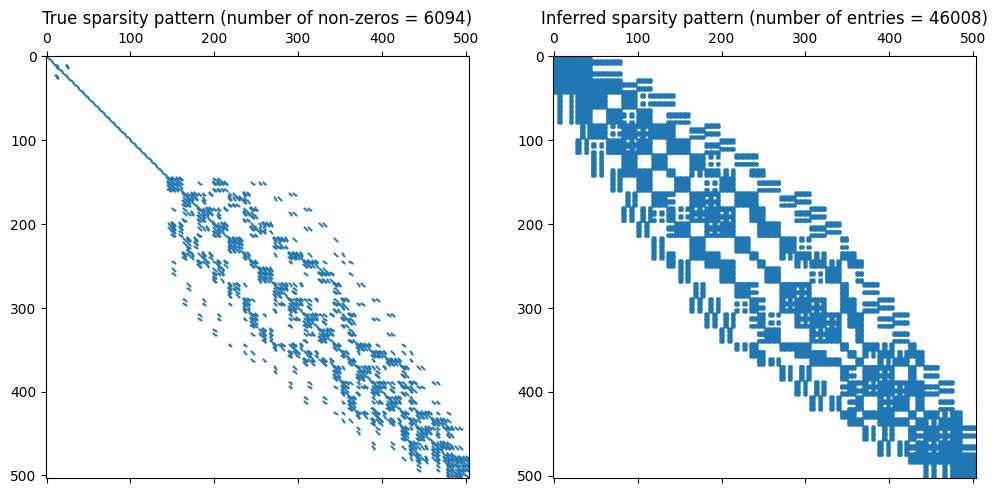

In [24]:
bilinear_form_csr_matrix = csr_matrix(bilinear_form_matrix.getValuesCSR()[::-1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].spy(bilinear_form_csr_matrix, markersize=0.5)
axes[0].set_title(f"True sparsity pattern (number of non-zeros = {bilinear_form_csr_matrix.count_nonzero()})")
axes[1].spy(bilinear_form_csr_matrix, markersize=0.5, precision="present")
axes[1].set_title(f"Inferred sparsity pattern (number of entries = {bilinear_form_csr_matrix.nnz})");

Extract solution at final time

In [25]:
final_velocity_function_space, dofmap_final_velocity_to_mixed = mixed_function_space.sub(0).sub( number_of_time_slices ).collapse()
final_velocity = dolfinx.fem.Function(final_velocity_function_space)
final_velocity.x.array[:] = velocity_primal_solution.x.array[dofmap_final_velocity_to_mixed] 

final_velocity_dual_function_space, dofmap_final_dual_velocity_to_mixed_dual = mixed_function_space.sub(1).sub( number_of_time_slices -1 ).collapse()
final_velocity_dual = dolfinx.fem.Function(final_velocity_dual_function_space)
final_velocity_dual.x.array[:] = velocity_dual_solution.x.array[dofmap_final_dual_velocity_to_mixed_dual] 

In [26]:
np.any(np.isinf(final_velocity.x.array))

False

In [27]:
final_velocity.x.array

array([0.00000000e+00, 0.00000000e+00, 4.78343769e-07, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.44288721e-02, 4.32724612e-02, 2.61564652e-02, 2.58655367e-02,
       3.56110294e-02, 2.61564652e-02, 6.85904714e-02, 5.78252262e-02,
       5.03410189e-02, 5.17305947e-02, 5.09642488e-02, 6.93973295e-02,
       9.27520702e-02, 9.03491999e-02, 6.93474819e-02, 5.17305951e-02,
       7.92860358e-02, 6.96384107e-02, 9.18633083e-02, 8.87405999e-02,
       9.27520705e-02, 1.02628553e-01, 8.47125811e-02, 1.03572962e-01,
       1.09640145e-01, 1.08522320e-01, 8.69643692e-02, 1.22858985e-01,
       1.18169945e-01, 1.12505036e-01, 1.25981693e-01, 1.26809197e-01,
       1.35970093e-01, 1.44083014e-01, 1.30080270e-01, 1.39458351e-01,
       1.48772054e-01, 1.54169744e-01, 1.58085758e-01, 1.58085758e-01])

In [28]:
final_velocity_dual.x.array

array([0.00000000e+00, 0.00000000e+00, 2.01555328e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.93794055e-02, 2.14738383e-02, 1.25042337e-02, 1.51006484e-02,
       1.88214030e-02, 1.43407860e-02, 3.81337506e-02, 2.64865962e-02,
       2.55003407e-02, 2.14172518e-02, 2.69964063e-02, 3.56824177e-02,
       4.43044906e-02, 4.67956886e-02, 3.18307122e-02, 3.08746084e-02,
       4.03952780e-02, 3.71570052e-02, 5.00032125e-02, 4.39613074e-02,
       5.17114129e-02, 5.05273675e-02, 4.18724997e-02, 5.21089874e-02,
       5.66746153e-02, 5.12481322e-02, 4.52388497e-02, 6.25206254e-02,
       5.77419059e-02, 6.10768378e-02, 6.22723320e-02, 6.01285874e-02,
       6.72775366e-02, 6.73102996e-02, 6.19799351e-02, 7.06785325e-02,
       7.03847218e-02, 7.13326602e-02, 7.30887573e-02, 7.23240912e-02])

Compute L2 error of numerical solution compared to exact

In [29]:
# measuring error 
exact_velocity_solution = ufl.sin(ufl.pi * final_time) * ufl.sin(ufl.pi * spatial_coordinate[0])
l2_error_squared_form = dolfinx.fem.form(
    ufl.inner(
        final_velocity - exact_velocity_solution, 
        final_velocity - exact_velocity_solution
    ) * cell_integral
)
l2_error_squared_local = dolfinx.fem.assemble_scalar(l2_error_squared_form)
l2_error_global = np.sqrt(mesh.comm.allreduce(l2_error_squared_local, op=MPI.SUM))
print(f"t = {final_time}, L2 error = {l2_error_global} ")

t = 0.9, L2 error = 0.17322904732201286 
